In [1]:
# Importing the librares
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import initializers

In [2]:
# load the data
data = pd.read_csv("../input/mechanical-properties-of-low-alloy-steels/MatNavi Mechanical properties of low-alloy steels.csv")
print(data.head())

columns = data.columns
print(*columns,  sep = " | ")

  Alloy code     C    Si    Mn      P      S     Ni    Cr    Mo    Cu    V  \
0        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
1        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
2        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
3        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
4        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   

      Al       N  Ceq  Nb + Ta   Temperature (°C)   0.2% Proof Stress (MPa)  \
0  0.003  0.0066  0.0      0.0                 27                       342   
1  0.003  0.0066  0.0      0.0                100                       338   
2  0.003  0.0066  0.0      0.0                200                       337   
3  0.003  0.0066  0.0      0.0                300                       346   
4  0.003  0.0066  0.0      0.0                400                       316   

    Tensile Strength (MPa)   Elongation (%)   Reduction 

<AxesSubplot:>

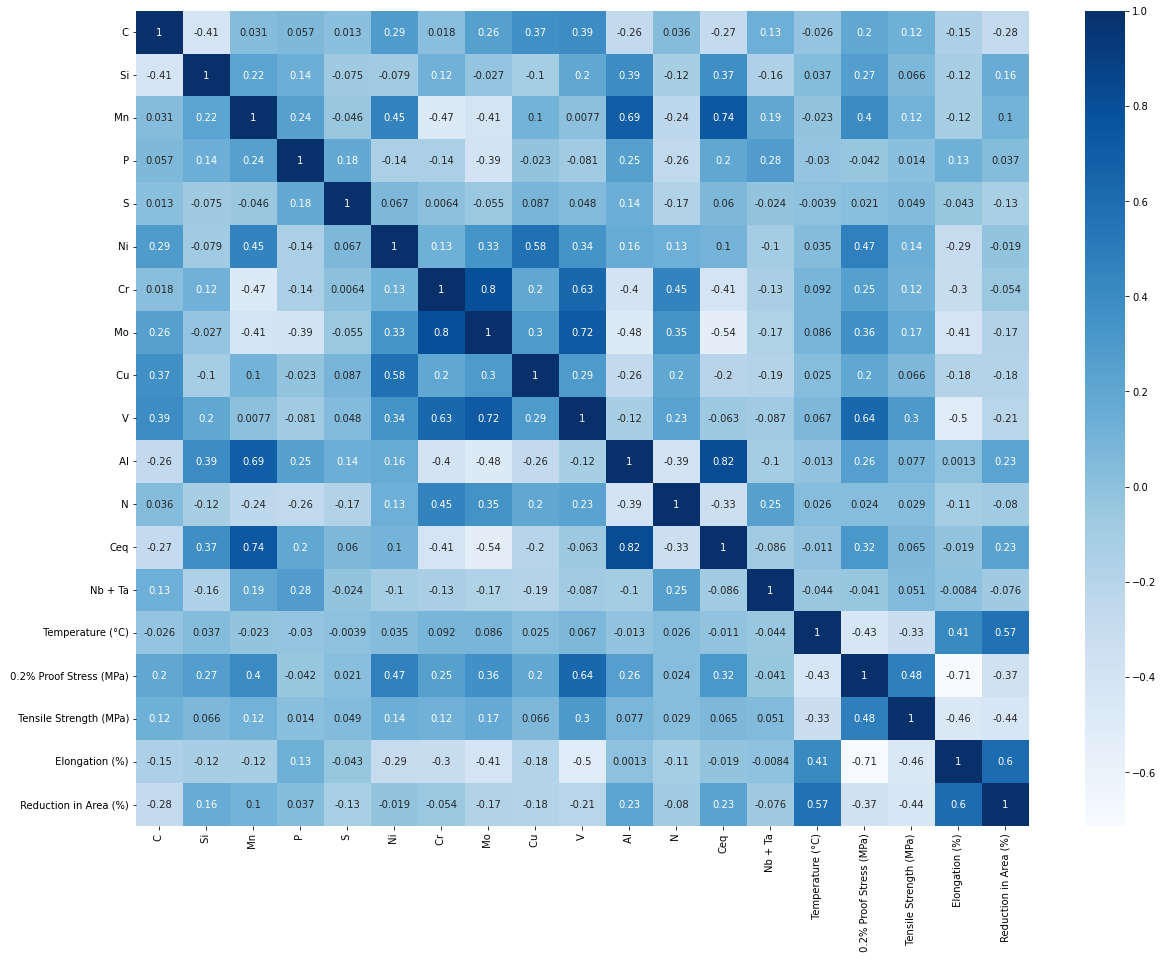

In [3]:
# correlation matrix; 

corr = data.corr()
plt.figure(figsize = (20,15), facecolor = (1, 1,1))
sns.heatmap(corr, cmap = "Blues", annot = True)

In [4]:
# separate alloy compositon as x and mechanical properties as y

x = data.iloc[:, 1:16].values
y = data.iloc[:, 16:].values

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, shuffle = True, random_state = 45)

In [5]:
print(x_train.size, x_test.size) # test size of the data

9600 4125


In [6]:
# normalize the data

sc_x = StandardScaler()
sc_x.fit(x_train)
x_train_sc = sc_x.transform(x_train)
x_test_sc = sc_x.transform(x_test)

sc_y = StandardScaler()
sc_y.fit(y_train)
y_train_sc = sc_y.transform(y_train)
y_test_sc = sc_y.transform(y_test)


In [7]:
# build the model
# here model contains 1 input layer, 2 hidden layers and 1 output layer

model = Sequential()
model.add(Dense(units = 15, kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros(), activation = 'tanh', input_dim = 15))
model.add(Dropout(0.1))
model.add(Dense(units = 40, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dense(units = 25, kernel_initializer = 'normal', activation = 'tanh'))
model.add(Dense(units = 4, kernel_initializer = 'normal', activation = 'tanh'))

model.compile(optimizer = 'adam', loss = 'mae')


2022-09-19 04:28:43.581939: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                240       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1025      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 104       
Total params: 2,009
Trainable params: 2,009
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time
history = model.fit(x_train_sc, y_train_sc,
                    validation_data = (x_test_sc, y_test_sc), batch_size = 126, shuffle = True, epochs = 2000, verbose = 0)
y_nn_pred_sc = model.predict(x_test_sc)

2022-09-19 04:28:43.786937: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 1min 42s, sys: 12.3 s, total: 1min 54s
Wall time: 1min 42s


       loss  val_loss
0  0.707763  0.691204
1  0.706021  0.688753
2  0.703078  0.684363
3  0.697656  0.676329
4  0.687805  0.661434
Minimum Validation Loss: 0.2448


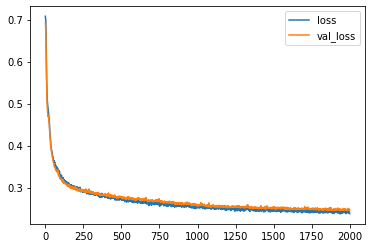

In [10]:
history_df = pd.DataFrame(history.history)
print(history_df.head())
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [11]:
r2_nn = r2_score(y_test_sc, y_nn_pred_sc)
print("Model R\u00b2_score: " + str(round(r2_nn, 2)))
mse_nn = mean_squared_error(y_test_sc, y_nn_pred_sc)
mae_nn = mean_absolute_error(y_test_sc, y_nn_pred_sc)

print('mean_squared_error = ' + str(round(mse_nn, 2)) )
print('mean_absolute_error = ' + str(round(mae_nn, 2)) )

Model R²_score: 0.81
mean_squared_error = 0.19
mean_absolute_error = 0.25


In [12]:
true_proof_strength = np.transpose(y_test)[0]
true_tensile_strength = np.transpose(y_test)[1]
true_pct_elongation = np.transpose(y_test)[2]
true_pct_reduction_area = np.transpose(y_test)[3]


y_nn_pred = sc_y.inverse_transform(y_nn_pred_sc)

# Visualizing the accuracy of predicted values
nn_predicted_proof_strength = np.transpose(y_nn_pred)[0]
nn_predicted_tensile_strength = np.transpose(y_nn_pred)[1]
nn_predicted_pct_elongation = np.transpose(y_nn_pred)[2]
nn_predicted_pct_reduction_area = np.transpose(y_nn_pred)[3]



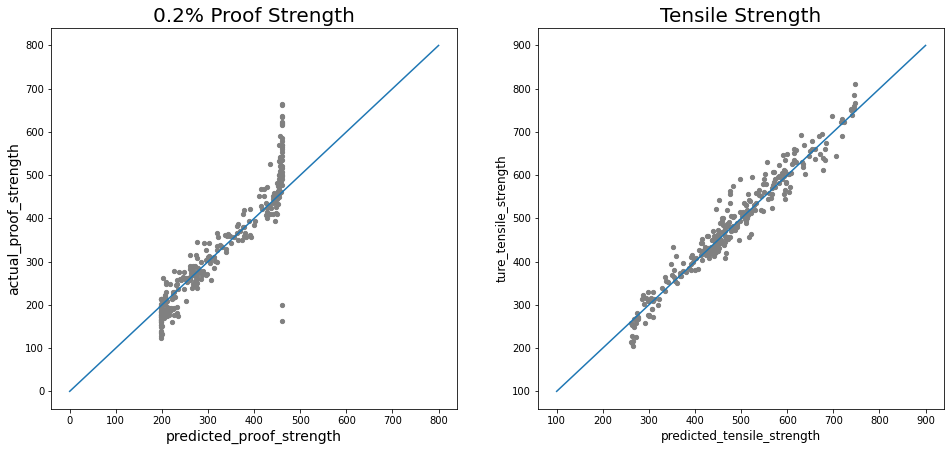

In [13]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,7))

ax0.scatter(nn_predicted_proof_strength, true_proof_strength, color = 'gray', s=18)
x3 = np.linspace(0, 800, 1000)
y3 = x3
ax0.plot(x3, y3)
ax0.set_title('0.2% Proof Strength', fontsize = 20)
ax0.set_xlabel('predicted_proof_strength', fontsize = 14)
ax0.set_ylabel('actual_proof_strength', fontsize = 14)

ax1.scatter(nn_predicted_tensile_strength, true_tensile_strength, color = 'gray', s=18)
x4 = np.linspace(100, 900, 1000)
y4 = x4
ax1.plot(x4, y4)
ax1.set_title('Tensile Strength', fontsize = 20)
ax1.set_xlabel('predicted_tensile_strength', fontsize = 12)
ax1.set_ylabel('ture_tensile_strength', fontsize = 12)

plt.show()

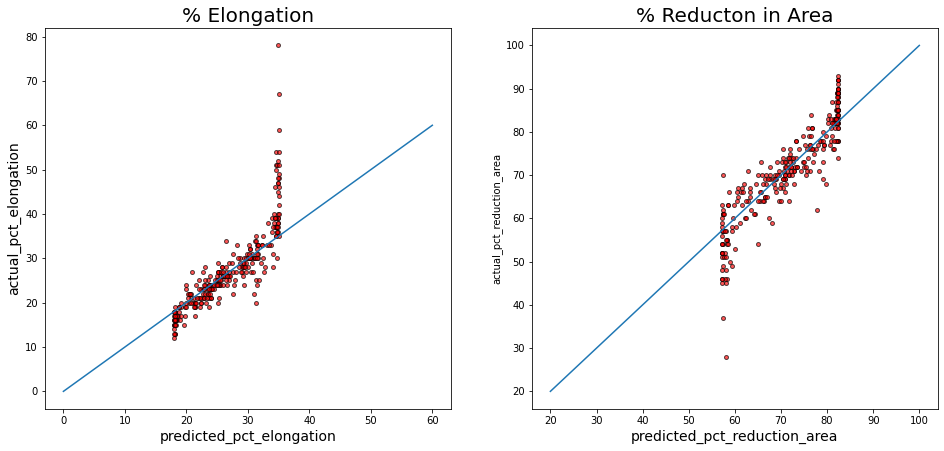

In [14]:
fig, (ax2,ax3) = plt.subplots(1,2,figsize=(16,7))

ax2.scatter(nn_predicted_pct_elongation, true_pct_elongation, color = 'red', s=16, edgecolor = 'black', alpha = 0.66)
x3 = np.linspace(0, 60, 1000)
y3 = x3
ax2.plot(x3, y3)
ax2.set_title('% Elongation', fontsize = 20)
ax2.set_xlabel('predicted_pct_elongation', fontsize = 14)
ax2.set_ylabel('actual_pct_elongation', fontsize = 14)

ax3.scatter(nn_predicted_pct_reduction_area, true_pct_reduction_area, color = 'red', s=16, edgecolor = 'black', alpha = 0.66)
x4 = np.linspace(20, 100, 1000)
y4 = x4
ax3.plot(x4, y4)
ax3.set_title('% Reducton in Area', fontsize = 20)
ax3.set_xlabel('predicted_pct_reduction_area', fontsize = 14)
ax3.set_ylabel('actual_pct_reduction_area')

plt.show()

In [16]:
r2_proof_strength_nn = r2_score(true_proof_strength, nn_predicted_proof_strength)
r2_tensile_strength_nn = r2_score(true_tensile_strength, nn_predicted_tensile_strength)
r2_pct_elongation_nn = r2_score(true_pct_elongation, nn_predicted_pct_elongation)
r2_pct_reduction_area_nn = r2_score(true_pct_reduction_area, nn_predicted_pct_reduction_area)
print('R\u00b2_score for 0.2% Proof Strength = ' + str(round(r2_proof_strength_nn, 2)))
print('R\u00b2_score for Tensile strength    = ' + str(round(r2_tensile_strength_nn, 2)))
print('R\u00b2_score for % Elongation        = ' + str(round(r2_pct_elongation_nn, 2)))
print('R\u00b2_score for % Reduction in Area = ' + str(round(r2_pct_reduction_area_nn, 2)))

R²_score for 0.2% Proof Strength = 0.84
R²_score for Tensile strength    = 0.95
R²_score for % Elongation        = 0.65
R²_score for % Reduction in Area = 0.8
